# Модель выделения коллекторов

## Содержание

* [Постановка задачи](#Постановка задачи)
* [Датасет](#Датасет)
* [Архитектура](#Архитектура)
* [Обучение](#Обучение)
* [Инференс](#Инференс)
* [Оценка модели](#Оценка-модели)
* [Краткое резюме](#Краткое-резюме)

## Постановка задачи

На основании каротажных данных выделить пропластки, являющиеся коллекторами.

## Датасет

Для обучения и оценки качества модели используются каротажи по скважинам месторождения "Крайнее".

Так как только один каротаж был измерен для всех скважин месторождения, был выделен набор каротажей, одновременно измеренных как минимум для 90% скважин. В него вошло 12 каротажей: CFTC, CILD, GR, GZ1, GZ2, GZ3, GZ4, GZ7, LLD, NKTD, PROX и SP. Этот набор каротажей был измерен для 321 скважины месторождения. Индикатор коллектора был получен из файлов с результатами интерпретации.

Полученный датасет был разбит на обучающую и тестовую выборки в соотношении 80:20.

In [1]:
import os
import sys
from copy import deepcopy
from functools import partial
sys.path.insert(0, os.path.join("..", "..", "..", ".."))

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

from well_logs import batchflow as bf
from well_logs import WellLogsDataset
from well_logs.batchflow.models.tf import UNet
from well_logs.batchflow.models.tf.losses import softmax_cross_entropy, dice

In [2]:
WELL_NPZ_PATH = "/home/alexander/Documents/Data/Крайнее ГИС РИГИС/npz/*.npz"
ds = WellLogsDataset(path=WELL_NPZ_PATH, no_ext=True, sort=True)
ds.split(0.8, shuffle=42)

## Архитектура

Для решения задачи используется модель U-Net, общее описание ее архитектуры доступно по ссылке https://analysiscenter.github.io/batchflow/api/batchflow.models.tf.unet.html

Модель обучается на кропах длины 256 из исходных каротажей.

Выбранная конфигурация модели:
* размерность входного слоя - [256, 12]
* размерность выходного слоя - [256, 1]
* количество фильтров в слоях энкодера и соответствующих им слоях декодера - [16, 16, 32, 32].

Задание конфигурации модели:

In [3]:
CROP_SIZE = 256

def sigmoid(x):
    return tf.sigmoid(x)[..., 0]

def loss(labels, logits, alpha=2, beta=1, *args, **kwargs):
    loss = (alpha * tf.losses.sigmoid_cross_entropy(labels, logits) +
            beta * dice(labels, logits))
    return loss

model_config = {
    "initial_block/inputs": "x",
    "head/num_classes": 1,
    "inputs": dict(x={"shape": (CROP_SIZE, 12)}, 
                   y={"name": "targets", "shape": (CROP_SIZE, 1)}),
    "body/filters": [16, 16, 32, 32],
    "body/encoder": dict(layout="cnacna", kernel_size=3),
    "body/decoder": dict(layout="cnacna", kernel_size=3),
    "body/upsample": dict(layout="tna", kernel_size=2, strides=2),
    "head": dict(layout="c"),
    "loss": loss,
    "optimizer": "Adam",
    "output": sigmoid,
}

## Обучение

Обучение происходит итерациями по батчам. Итерации состоят из:
* генерации очередной порции данных
* обновления весов нейронной сети.

Для обучения выбран оптимизатор Adam с параметрами по умолчанию:
* learning_rate = 0.001
* beta1 = 0.9
* beta2 = 0.999
* epsilon = 1e-08.

Функция потерь - бинарная кроссэнтропия.

Схема обхода датасета:
* размер батча - 32
* количество эпох - 500.

Описание пайплайна обучения:

In [4]:
N_EPOCH = 100
BATCH_SIZE = 32

In [5]:
def concatenate_batch(batch, model, concat_mask=True):
    feed_dict = {"x": np.concatenate(batch.logs).swapaxes(1, 2)}
    if concat_mask:
        feed_dict["y"] = np.concatenate(batch.mask)[..., np.newaxis]
    return {"feed_dict": feed_dict}

In [6]:
template_train_ppl = (
    bf.Pipeline()
      .add_components("mask", bf.B("array_of_nones"))
      .init_model("dynamic", UNet, name="unet", config=model_config)
      .init_variable("loss_history", init_on_each_run=list)
      .load(fmt="npz", components=["dept", "logs", "mask"])
      .drop_nans(components_to_split="mask")
      .standardize(components="logs")
      .random_crop(CROP_SIZE, n_crops=4, components=["logs", "mask"])
      .train_model("unet", make_data=concatenate_batch,
                   fetches="loss", save_to=bf.V("loss_history"), mode="a")
      .run(batch_size=BATCH_SIZE, n_epochs=N_EPOCH, shuffle=True, drop_last=True,
           lazy=True, bar=True)
)

Запуск процедуры обучения:

In [7]:
train_ppl = (ds.train >> template_train_ppl)
train_ppl.run()

100%|██████████| 800/800 [08:07<00:00,  1.70it/s]


График функции потерь в зависимости от числа эпох:

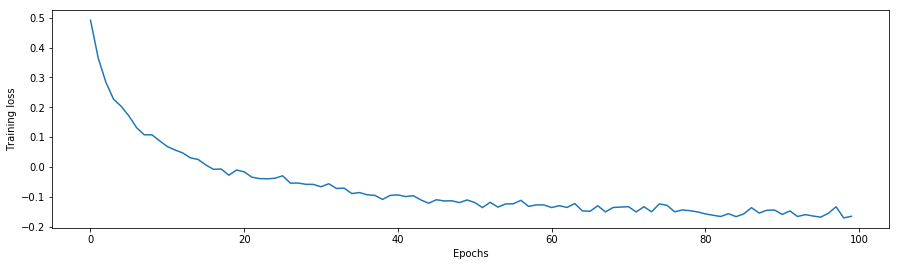

In [8]:
train_loss = [np.mean(l) for l in np.array_split(train_ppl.get_variable("loss_history"), N_EPOCH)]

fig = plt.figure(figsize=(15, 4))
plt.plot(train_loss)
plt.xlabel("Epochs")
plt.ylabel("Training loss")
plt.show()

## Инференс

Пайплайн для получения сегментации:

In [9]:
template_predict_ppl = (
    bf.Pipeline()
      .add_components("mask", bf.B("array_of_nones"))
      .add_components("pred", bf.B("array_of_nones"))
      .import_model("unet", train_ppl)
      .load(fmt="npz", components=["dept", "logs", "mask"])
      .drop_nans(components_to_split="mask")
      .standardize(components="logs")
      .crop(CROP_SIZE, step=CROP_SIZE // 8, components="logs")
      .predict_model("unet", make_data=partial(concatenate_batch, concat_mask=False),
                     fetches="sigmoid", save_to=bf.B("pred"), mode="w")
      .split_by_well(components="pred")
      .aggregate(components="pred")
      .run(batch_size=1, n_epochs=1, shuffle=False, drop_last=False, lazy=True)
)

predict_ppl = (ds.test >> template_predict_ppl)

Запуск сегментации и визуализация предсказания модели:

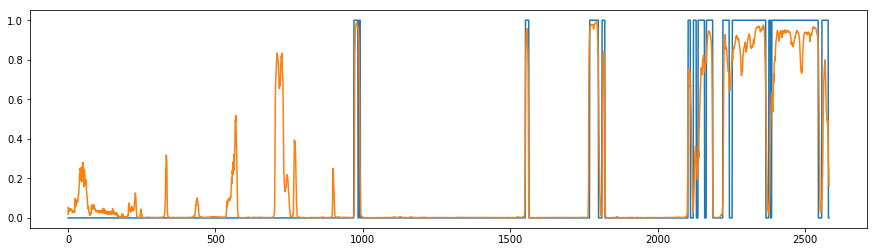

In [10]:
batch = predict_ppl.next_batch()

plt.figure(figsize=(15, 4))
plt.plot(batch.mask[0])
plt.plot(batch.pred[0])
plt.show()

## Оценка модели

Качество модели определяется средним значением метрики F1-score по каротажам из тестового набора данных.

Описание процедуры расчета метрики:

In [11]:
template_test_ppl = (
    bf.Pipeline()
      .add_components("mask", bf.B("array_of_nones"))
      .add_components("pred", bf.B("array_of_nones"))
      .import_model("unet", train_ppl)
      .init_variable("mask", init_on_each_run=list)
      .init_variable("pred", init_on_each_run=list)
      .load(fmt="npz", components=["dept", "logs", "mask"])
      .drop_nans(components_to_split="mask")
      .standardize(components="logs")
      .crop(CROP_SIZE, step=CROP_SIZE // 8, components="logs")
      .predict_model("unet", make_data=partial(concatenate_batch, concat_mask=False),
                     fetches="sigmoid", save_to=bf.B("pred"), mode="w")
      .split_by_well(components="pred")
      .aggregate(components="pred")
      .update_variable("mask", bf.B("mask"), mode="a")
      .update_variable("pred", bf.B("pred"), mode="a")
      .run(batch_size=BATCH_SIZE, n_epochs=1, shuffle=False, drop_last=False, lazy=True)
)

test_ppl = (ds.test >> template_test_ppl)

Запуск расчета метрики:

In [12]:
test_ppl.run()

mask = sum((arr.tolist() for arr in test_ppl.get_variable("mask")), [])
pred = sum((arr.tolist() for arr in test_ppl.get_variable("pred")), [])
f1_scores = [f1_score(m, p > 0.5) for m, p in zip(mask, pred)]

In [13]:
np.mean(f1_scores)

0.5893509496025188

In [14]:
mask_concat = np.concatenate(mask)
pred_concat = np.concatenate(pred)
f1_score_concat = f1_score(mask_concat, pred_concat > 0.5)

In [15]:
f1_score_concat

0.6718098641113095

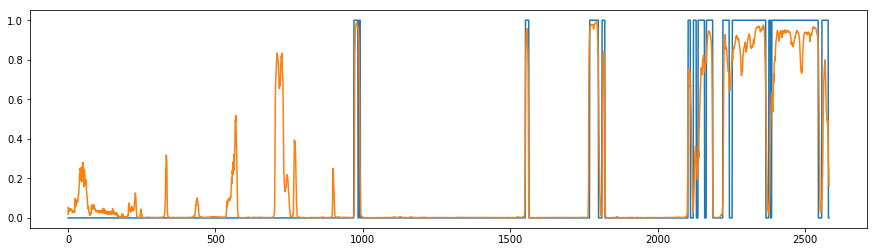

In [16]:
ix = np.argmax(f1_scores)
plt.figure(figsize=(15, 4))
plt.plot(mask[ix])
plt.plot(pred[ix])
plt.show()

## Краткое резюме

На основе каротажных данных месторождения "Крайнее" была обучена модель выявления коллекторов. Точность модели по метрике F1-score для класса "коллектор" по исходным каротажам составила 0.59.